<a href="https://colab.research.google.com/github/Otobi1/Online-Retail-Transactions/blob/master/Online_Retail_Transactions_Customer_Segmentation_w_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
# Installing lifetimes and jcopml quietly (without the install logs)

!pip install lifetimes --quiet 
!pip install jcopml --quiet 

In [1]:
# Importing the necessary libraries 

import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from matplotlib.image import imread
import seaborn as sns
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import  cosine_similarity
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from lifetimes.utils import summary_data_from_transaction_data
from jcopml.plot import plot_missing_value

# Hopkins statistics - tells us how much data is suitable to cluster 

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')
from warnings import filterwarnings
filterwarnings('ignore')

print ('Libraries successfully imported!')

Libraries successfully imported!


In [2]:
# Mount the drive, because the data is already on the GDrive

from google.colab import drive # for more on writing and reading files through colab https://towardsdatascience.com/reading-and-writing-files-with-google-colaboratory-f0c234683946
drive.mount("/drive") 

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [3]:
# Loading the dataset from the GDrive

clean_final_retail_data = pd.read_csv("/drive/My Drive/Colab Notebooks/clean_final_retail_data.csv")

In [4]:
# Exploring the first 5 observations in the dataset

clean_final_retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
# Creating a new column called total cost by multiplying the quantity and price

clean_final_retail_data['TotalCost'] = clean_final_retail_data['Quantity'] * clean_final_retail_data['Price']

clean_final_retail_data.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalCost
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,39.6
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom,59.5
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,30.6
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom,45.0


In [6]:
# Renaming the variables/features for ease of understanding, clarity and handling

features = {'Invoice' : 'Invoice', 
            'StockCode': 'StockCode', 
            'Description': 'Description', 
            'Quantity': 'Quantity', 
            'InvoiceDate': 'InvoiceDate', 
            'Price' : 'UnitPrice', 
            'Customer ID': 'CustomerID', 
            'Country': 'Country', 
            'TotalCost': 'TotalCost'}

clean_final_retail_data = clean_final_retail_data.rename(columns=features)

clean_final_retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalCost
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [7]:
# Checking the data types of the new dataframe

clean_final_retail_data.dtypes

Invoice          int64
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
TotalCost      float64
dtype: object

In [8]:
# Exploring the descriptives of the non-numeric variables (categorical variables)

clean_final_retail_data.describe(exclude='number')

,StockCode,Description,InvoiceDate,Country
count,805549,805549,805549,805549
unique,4631,5283,34585,41
top,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-11-14 15:27:00,United Kingdom
freq,5188,5181,542,725250


In [ ]:
## Apparently there are still some missing values in the dataset

## Also some of the observations are from outside UK

In [9]:
# Checking the descriptives of the numerical variables 

clean_final_retail_data.describe()

,Invoice,Quantity,UnitPrice,CustomerID,TotalCost
count,805549.000000,805549.000000,805549.000000,805549.000000,805549.000000
mean,537410.713358,13.290522,3.206561,15331.954970,22.026505
std,26666.068909,143.634088,29.199173,1696.737039,224.041928
min,489434.000000,1.000000,0.001000,12346.000000,0.001000
25%,514962.000000,2.000000,1.250000,13982.000000,4.950000
50%,536989.000000,5.000000,1.950000,15271.000000,11.850000
75%,561617.000000,12.000000,3.750000,16805.000000,19.500000
max,581587.000000,80995.000000,10953.500000,18287.000000,168469.600000


In [10]:
# Exploring the descriptives of all the variables both numerics and categorical data types

clean_final_retail_data.describe(include='all')

,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalCost
count,805549.000000,805549,805549,805549.000000,805549,805549.000000,805549.000000,805549,805549.000000
unique,NaN,4631,5283,NaN,34585,NaN,NaN,41,NaN
top,NaN,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-11-14 15:27:00,NaN,NaN,United Kingdom,NaN
freq,NaN,5188,5181,NaN,542,NaN,NaN,725250,NaN
mean,537410.713358,NaN,NaN,13.290522,NaN,3.206561,15331.954970,NaN,22.026505
std,26666.068909,NaN,NaN,143.634088,NaN,29.199173,1696.737039,NaN,224.041928
min,489434.000000,NaN,NaN,1.000000,NaN,0.001000,12346.000000,NaN,0.001000
25%,514962.000000,NaN,NaN,2.000000,NaN,1.250000,13982.000000,NaN,4.950000
50%,536989.000000,NaN,NaN,5.000000,NaN,1.950000,15271.000000,NaN,11.850000
75%,561617.000000,NaN,NaN,12.000000,NaN,3.750000,16805.000000,NaN,19.500000


In [11]:
# Dimensions of the dataframe

clean_final_retail_data.shape

(805549, 9)

In [12]:
# Converting the InvoiceDate data type from object to datetime

clean_final_retail_data['InvoiceDate'] = pd.to_datetime(clean_final_retail_data['InvoiceDate'])

clean_final_retail_data.dtypes

Invoice                 int64
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
TotalCost             float64
dtype: object

In [13]:
# Checking the proportion of customers for each country represented in the dataframe

clean_final_retail_data.Country.value_counts(normalize=True)

# majority of the customers (more than 90%) are in the UK

United Kingdom          0.900318
Germany                 0.020724
EIRE                    0.019543
France                  0.017146
Netherlands             0.006316
Spain                   0.004617
Belgium                 0.003809
Switzerland             0.003738
Portugal                0.003036
Australia               0.002249
Channel Islands         0.001948
Italy                   0.001822
Norway                  0.001783
Sweden                  0.001637
Cyprus                  0.001434
Finland                 0.001281
Austria                 0.001145
Denmark                 0.000991
Greece                  0.000816
Unspecified             0.000647
Poland                  0.000636
Japan                   0.000602
USA                     0.000508
United Arab Emirates    0.000475
Singapore               0.000421
Israel                  0.000400
Malta                   0.000350
Iceland                 0.000314
Canada                  0.000283
Lithuania               0.000235
RSA       

In [14]:
# Extracting the actual proportion of customers in the UK. 
# Using a conditional statement to select unique customer IDs where customer country is equal to UK and dividing by the total unique customer ID

clean_final_retail_data[clean_final_retail_data['Country'] == 'United Kingdom'].CustomerID.nunique()/clean_final_retail_data.CustomerID.nunique()

0.9101735284110242

In [15]:
# Extracting the dataframe for UK customers only and checking the dimensions

clean_final_retail_uk_data = clean_final_retail_data[clean_final_retail_data['Country'] == 'United Kingdom']

clean_final_retail_uk_data.shape

(725250, 9)

In [16]:
# Ensuring that there are no observations with zero quantities 

clean_final_retail_uk_data = clean_final_retail_uk_data[clean_final_retail_uk_data['Quantity'] > 0]

clean_final_retail_uk_data.shape

(725250, 9)

In [17]:
# Checking to ensure that there are no missing values left in the dataset
# Specifically for the customer ID, since we doing a customer segmentation 

clean_final_retail_uk_data.dropna(subset=['CustomerID'], how='all', inplace=True)

clean_final_retail_uk_data.shape

(725250, 9)

In [18]:
# Checking the maximum date (latest date) in the transaction

clean_final_retail_uk_data['InvoiceDate'].max()

# Which is the 9th of December 2011

Timestamp('2011-12-09 12:49:00')

In [19]:
# And the lowest date (earliest date) in the transaction

clean_final_retail_uk_data['InvoiceDate'].min()

# 1st December 2009

Timestamp('2009-12-01 07:45:00')

In [20]:
# Restriciting the data to one full year, as its better to use a metric per month or per year in RFM
# So we select the observations from 9th December 2010 - 9th December 2011

clean_final_retail_uk_data = clean_final_retail_uk_data[clean_final_retail_uk_data['InvoiceDate'] >= '2010-12-09']

clean_final_retail_uk_data.shape

(343955, 9)

In [21]:
# Checking the latest date for the one year adjusted timeframe

clean_final_retail_uk_data['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

In [22]:
# Checking the earliest date for the one year adjusted timeframe

clean_final_retail_uk_data['InvoiceDate'].min()

Timestamp('2010-12-09 08:34:00')

In [23]:
# Exploring the average total quantity of products purchased by a customer

np.mean(clean_final_retail_uk_data.groupby('CustomerID').Quantity.sum())

1073.0126877265666

In [24]:
# Exploring the average total amount spent by a customer 

np.mean(clean_final_retail_uk_data.groupby('CustomerID').TotalCost.sum())

1835.0632998446379

In [25]:
# Checking the average quantity overall in the dataset
# This implies that the primary key is the InvoiceNo-StockCode-CustomerID representing one purchase transaction

clean_final_retail_uk_data.Quantity.mean()

12.048015001962465

In [26]:
# Checking the average totalcost overall in the dataset

clean_final_retail_uk_data.TotalCost.mean()

20.60448158626205

In [27]:
# Exploring the total number of unique stockcodes (items available)

clean_final_retail_uk_data.StockCode.nunique()

3611

In [28]:
# Summarising some key metrics

print ('UK summary')
print ('Number of invoices: ', clean_final_retail_uk_data['Invoice'].nunique())
print ('Number of products bought: ', clean_final_retail_uk_data['StockCode'].nunique())
print ('Number of customers: ', clean_final_retail_uk_data['CustomerID'].nunique())
print ('Percentage of customers NA: ', round(clean_final_retail_uk_data['CustomerID'].isnull().sum() * 100 / len(clean_final_retail_uk_data), 2), '%')
print ('Average quantity of product purchased by a customer: ', round(np.mean(clean_final_retail_uk_data.groupby('CustomerID').Quantity.sum()), 0))
print ('Average product quantity sold per transaction: ', round(clean_final_retail_uk_data.Quantity.mean(), 0))
print ('Average revenue generated per transaction: ', round(clean_final_retail_uk_data.TotalCost.mean(), 2))

UK summary
Number of invoices:  16014
Number of products bought:  3611
Number of customers:  3862
Percentage of customers NA:  0.0 %
Average quantity of product purchased by a customer:  1073.0
Average product quantity sold per transaction:  12.0
Average revenue generated per transaction:  20.6


In [29]:
# Exploring the descriptives of categorical features in the UK dataset

clean_final_retail_uk_data.describe(exclude='number')

,StockCode,Description,InvoiceDate,Country
count,343955,343955,343955,343955
unique,3611,3799,15037,1
top,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-11-14 15:27:00,United Kingdom
freq,1869,1862,542,343955
first,NaN,NaN,2010-12-09 08:34:00,NaN
last,NaN,NaN,2011-12-09 12:49:00,NaN


In [30]:
# Exploring the descriptives of the numerical features of the UK dataset

clean_final_retail_uk_data.describe()

,Invoice,Quantity,UnitPrice,CustomerID,TotalCost
count,343955.000000,343955.000000,343955.000000,343955.000000,343955.000000
mean,561386.116844,12.048015,2.961131,15544.720830,20.604482
std,12697.979790,191.916027,18.109384,1591.329019,330.527175
min,537879.000000,1.000000,0.001000,12346.000000,0.001000
25%,550311.000000,2.000000,1.250000,14191.000000,4.160000
50%,562570.000000,4.000000,1.850000,15513.000000,10.200000
75%,572552.000000,12.000000,3.750000,16928.000000,17.700000
max,581586.000000,80995.000000,8142.750000,18287.000000,168469.600000


In [31]:
# Checking the dataframe info

clean_final_retail_uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343955 entries, 405915 to 805532
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      343955 non-null  int64         
 1   StockCode    343955 non-null  object        
 2   Description  343955 non-null  object        
 3   Quantity     343955 non-null  int64         
 4   InvoiceDate  343955 non-null  datetime64[ns]
 5   UnitPrice    343955 non-null  float64       
 6   CustomerID   343955 non-null  float64       
 7   Country      343955 non-null  object        
 8   TotalCost    343955 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 26.2+ MB


In [32]:
"""Implementing RFM"""

'Implementing RFM'

In [33]:
# Recency 
# We need a reference date to estimate recency
# The difference (in days) between NOW (the reference date) and date of invoice will give us recency
# Range of recency will be (0, 365)

now = dt.date(2011, 12, 9)

print (now)

2011-12-09


In [34]:
# Creating a column for the date, extracted from the invoicedate variable

clean_final_retail_uk_data['Date'] = pd.DatetimeIndex(clean_final_retail_uk_data['InvoiceDate']).date

In [35]:
# Exploring the first 5 observations

clean_final_retail_uk_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalCost,Date
405915,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,47.4,2010-12-09
405916,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,37.2,2010-12-09
405917,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243.0,United Kingdom,15.3,2010-12-09
405918,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,31.8,2010-12-09
405919,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,15.9,2010-12-09


In [36]:
# Creating the recency dataframe

# Here, the maximum date (most recent date) for each customer's group of transaction is selected
recency_df = clean_final_retail_uk_data.groupby(by='CustomerID', as_index=False)['Date'].max()

# the columns are labelled to capture the customer ID and the date when tha latest purchase was made
recency_df.columns = ['CustomerID', 'LastPurchaseDate']

recency_df.head()

,CustomerID,LastPurchaseDate
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [37]:
# Calculating recency

# By deducting the last puchase date from "now", designated above.
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (now - x).days)

# Essentially how recent is each customer's last purchase in comparison to the designated "now"

In [38]:
recency_df.head()

,CustomerID,LastPurchaseDate,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


In [39]:
# Dropping the "LastPurchaseDate" variable from the recency dataframe

recency_df.drop('LastPurchaseDate', axis=1, inplace=True)

In [40]:
# Creating the frequency dataframe

# First make a clean copy of the original dataset
clean_final_retail_uk_data_copy = clean_final_retail_uk_data

# Next drop the duplicate entries (observations) specifically the invoice and customerID
clean_final_retail_uk_data_copy.drop_duplicates(subset = ['Invoice', 'CustomerID'], inplace=True)

# Now, group the invoices based on the customers and count the number of invoices per customer
frequency_df = clean_final_retail_uk_data_copy.groupby(by=['CustomerID'], as_index=False)['Invoice'].count()

# Specify the labels to the variabls
frequency_df.columns = ['CustomerID', 'Frequency']

frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,10
2,12748.0,195
3,12749.0,5
4,12820.0,4


In [41]:
# Exploring the information and description of the dataframe

clean_final_retail_uk_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16014 entries, 405915 to 805529
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      16014 non-null  int64         
 1   StockCode    16014 non-null  object        
 2   Description  16014 non-null  object        
 3   Quantity     16014 non-null  int64         
 4   InvoiceDate  16014 non-null  datetime64[ns]
 5   UnitPrice    16014 non-null  float64       
 6   CustomerID   16014 non-null  float64       
 7   Country      16014 non-null  object        
 8   TotalCost    16014 non-null  float64       
 9   Date         16014 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 1.3+ MB


In [42]:
# Creating the monetary value dataframe 

# Amount spent by each individual customer 
# Computed by aggregating the total cost for each unique customer
monetary_df = clean_final_retail_uk_data.groupby(by='CustomerID', as_index=False)['TotalCost'].sum()

monetary_df.columns = ['CustomerID', 'Monetary']

monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,658.89
2,12748.0,3739.23
3,12749.0,98.35
4,12820.0,58.20


In [43]:
# RFM table 
# Merge the recency and frequency dataframes into a temp df

temp_df = recency_df.merge(frequency_df, on='CustomerID')
temp_df.head()

,CustomerID,Recency,Frequency
0,12346.0,325,1
1,12747.0,2,10
2,12748.0,0,195
3,12749.0,3,5
4,12820.0,3,4


In [44]:
# Merge the temp_df with the monetary dataframe 

rfm_df = temp_df.merge(monetary_df, on='CustomerID')

rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,10,658.89
2,12748.0,0,195,3739.23
3,12749.0,3,5,98.35
4,12820.0,3,4,58.20


In [45]:
# Making the 0's 1, in the recency column

rfm_df['Recency'] = rfm_df['Recency'] + 1

In [46]:
rfm_df.describe()

,CustomerID,Recency,Frequency,Monetary
count,3862.000000,3862.000000,3862.000000,3862.000000
mean,15556.033920,88.556447,4.146556,288.374744
std,1575.522276,94.187268,6.930316,3266.991142
min,12346.000000,1.000000,1.000000,0.390000
25%,14201.750000,18.000000,1.000000,17.400000
50%,15561.500000,50.000000,2.000000,45.000000
75%,16911.500000,135.000000,5.000000,121.625000
max,18287.000000,366.000000,195.000000,168471.250000


In [47]:
# Outlier treatment 
# Given that the algorithm is highly susceptible to outliers, we need to remove outliers

# For recency 
Q1 = rfm_df.Recency.quantile(0.25)
Q3 = rfm_df.Recency.quantile(0.75)

IQR = Q3 - Q1

rfm_df = rfm_df[(rfm_df.Recency >= (Q1 - 1.5 * IQR)) & (rfm_df.Recency <= (Q3 + 1.5 * IQR))]

rfm_df.describe()

# As seen below, the mean and std has reduced, the max and the 75% has also reduced

,CustomerID,Recency,Frequency,Monetary
count,3720.000000,3720.000000,3720.000000,3720.000000
mean,15555.140054,79.108871,4.260215,277.141626
std,1574.965476,82.263670,7.035349,3080.297517
min,12747.000000,1.000000,1.000000,0.390000
25%,14197.500000,17.000000,1.000000,17.700000
50%,15570.500000,46.000000,2.000000,46.800000
75%,16909.250000,116.000000,5.000000,125.425000
max,18287.000000,310.000000,195.000000,168471.250000


In [48]:
# For frequency

Q1 = rfm_df.Frequency.quantile(0.25)
Q3 = rfm_df.Frequency.quantile(0.75)

IQR = Q3 - Q1

rfm_df = rfm_df[(rfm_df.Frequency >= (Q1 - 1.5 * IQR)) & (rfm_df.Frequency <= (Q3 +1.5 * IQR))]

rfm_df.describe()

# As shown below, the distribution and the descriptives have also adjusted to exclude the outliers 

,CustomerID,Recency,Frequency,Monetary
count,3483.000000,3483.000000,3483.000000,3483.000000
mean,15558.796153,83.618145,3.021246,173.328243
std,1571.559883,82.962228,2.401442,2952.364923
min,12747.000000,1.000000,1.000000,0.390000
25%,14214.500000,20.000000,1.000000,17.000000
50%,15572.000000,51.000000,2.000000,41.240000
75%,16914.500000,128.000000,4.000000,101.385000
max,18287.000000,310.000000,11.000000,168471.250000


In [49]:
# For monetary

Q1 = rfm_df.Monetary.quantile(0.25)
Q3 = rfm_df.Monetary.quantile(0.75)

IQR = Q3 - Q1

rfm_df = rfm_df[(rfm_df.Monetary >= (Q1 - 1.5 * IQR)) & (rfm_df.Monetary <= (Q3 +1.5 * IQR))]

rfm_df.describe()

,CustomerID,Recency,Frequency,Monetary
count,3146.000000,3146.000000,3146.000000,3146.000000
mean,15559.520025,86.230769,2.736173,54.106135
std,1559.466439,84.187489,2.117309,51.658956
min,12749.000000,1.000000,1.000000,0.390000
25%,14227.500000,22.000000,1.000000,15.900000
50%,15571.500000,53.000000,2.000000,35.625000
75%,16896.500000,134.000000,4.000000,76.500000
max,18287.000000,310.000000,11.000000,227.400000


In [50]:
# Scaling,using StandardScaler or MinMaxScaler or manual scaling is important for K-Means clustering

# Scaling recency to the range (0,1)

# recency - recency.min / recency.max - recency.min

rfm_df['R'] = (rfm_df['Recency'] - rfm_df['Recency'].min()) / (rfm_df['Recency'].max() - rfm_df['Recency'].min())

In [51]:
# Scaling frequency to the range (0, 1)

rfm_df['F'] = (rfm_df['Frequency'] - rfm_df['Frequency'].min()) / (rfm_df['Frequency'].max() - rfm_df['Frequency'].min())

In [52]:
# Scaling the monetary to the range (0, 1)

rfm_df['M'] = (rfm_df['Monetary'] - rfm_df['Monetary'].min()) / (rfm_df['Monetary'].max() - rfm_df['Monetary'].min())

In [53]:
# the value of the customer is inversely proportional to the recency value and directly proportional to the frequency and the monetary values 

rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M
3,12749.0,4,5,98.35,0.009709,0.4,0.431523
4,12820.0,4,4,58.20,0.009709,0.3,0.254658
5,12821.0,215,1,19.92,0.692557,0.0,0.086031
6,12822.0,71,2,30.80,0.226537,0.1,0.133959
8,12824.0,60,1,5.04,0.190939,0.0,0.020484


In [54]:
# Making a copy of the rfm_df

df = rfm_df
df.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M
3,12749.0,4,5,98.35,0.009709,0.4,0.431523
4,12820.0,4,4,58.20,0.009709,0.3,0.254658
5,12821.0,215,1,19.92,0.692557,0.0,0.086031
6,12822.0,71,2,30.80,0.226537,0.1,0.133959
8,12824.0,60,1,5.04,0.190939,0.0,0.020484


In [56]:
# Exploring the descriptives of the dataframe

df.describe()

,CustomerID,Recency,Frequency,Monetary,R,F,M
count,3146.000000,3146.000000,3146.000000,3146.000000,3146.000000,3146.000000,3146.000000
mean,15559.520025,86.230769,2.736173,54.106135,0.275828,0.173617,0.236625
std,1559.466439,84.187489,2.117309,51.658956,0.272451,0.211731,0.227562
min,12749.000000,1.000000,1.000000,0.390000,0.000000,0.000000,0.000000
25%,14227.500000,22.000000,1.000000,15.900000,0.067961,0.000000,0.068323
50%,15571.500000,53.000000,2.000000,35.625000,0.168285,0.100000,0.155213
75%,16896.500000,134.000000,4.000000,76.500000,0.430421,0.300000,0.335272
max,18287.000000,310.000000,11.000000,227.400000,1.000000,1.000000,1.000000


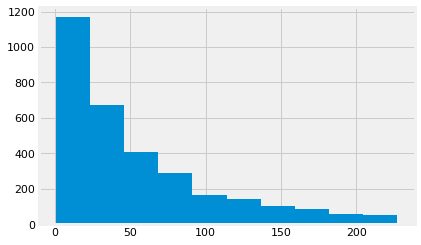

In [57]:
#df['Recency'].hist()
#df['Frequency'].hist()
df['Monetary'].hist()

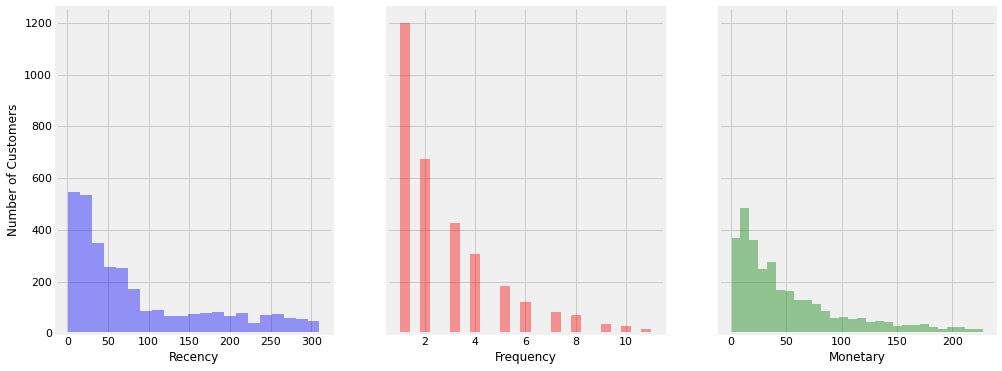

In [58]:
# Plotting the distribution plots of the scaled recency, frequency and monetary values

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,6))

sns.distplot(df['Recency'], ax=ax0, kde=False, color='b')
ax0.set(xlabel='Recency', ylabel='Number of Customers')

sns.distplot(df['Frequency'], ax=ax1, kde=False, color='r')
ax1.set(xlabel='Frequency')

sns.distplot(df['Monetary'], ax=ax2, kde=False, color='g')
ax2.set(xlabel='Monetary')

fig.savefig('Histograms of Attributes')

In [59]:
# Reseting the index for future concatenation purposes 
# Pandas needs same indexes to concatenate pd objects, else some rows will be lost

df.reset_index(drop = True, inplace=True)

df

,CustomerID,Recency,Frequency,Monetary,R,F,M
0,12749.0,4,5,98.35,0.009709,0.4,0.431523
1,12820.0,4,4,58.20,0.009709,0.3,0.254658
2,12821.0,215,1,19.92,0.692557,0.0,0.086031
3,12822.0,71,2,30.80,0.226537,0.1,0.133959
4,12824.0,60,1,5.04,0.190939,0.0,0.020484
...,...,...,...,...,...,...,...
3141,18278.0,74,1,17.00,0.236246,0.0,0.073169
3142,18280.0,278,1,23.70,0.896440,0.0,0.102683
3143,18281.0,181,1,5.04,0.582524,0.0,0.020484
3144,18282.0,8,2,38.25,0.022654,0.1,0.166777


In [60]:
# HOPKINS statistics - tells you how much data is suitable to cluster

def hopkins(X):
  d = X.shape[1] # d = len(vars) # columns
  n = len(X) # rows
  m = int(0.1 * n)
  nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

  rand_X = sample(range(0, n, 1), m)

  ujd = []
  wjd = []
  for j in range(0, m):
    u_dist, _ = nbrs.kneighbors(uniform(np.amin(X, axis=0), np.amax(X, axis=0), d).reshape(1, -1), 2, return_distance=True)
    ujd.append(u_dist[0][1])
    w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
    wjd.append(w_dist[0][1])
    
  H = sum(ujd) / (sum(ujd) + sum(wjd))
  if isnan(H):
    print(ujd, wjd)
    H = 0

  return H

In [62]:
hopkins(df[['R', 'F', 'M']])

# About 91% of the data is suitable for clustering

0.8993416764703311

In [63]:
# Making a new df with only the scaled R F M scores 

df_1 = df[['CustomerID', 'R', 'F', 'M']]
df_1.set_index('CustomerID', inplace = True)
df_1.head(20)

,R,F,M
CustomerID,,,
12749.0,0.009709,0.4,0.431523
12820.0,0.009709,0.3,0.254658
12821.0,0.692557,0.0,0.086031
12822.0,0.226537,0.1,0.133959
12824.0,0.190939,0.0,0.020484
12826.0,0.006472,0.6,0.539227
12827.0,0.016181,0.2,0.369235
12828.0,0.006472,0.5,0.680190
12831.0,0.847896,0.0,0.148936


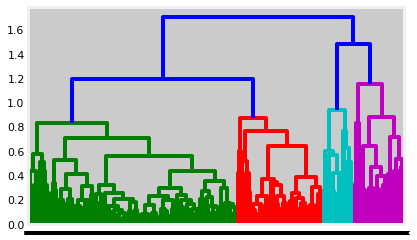

In [66]:
# Dendrogram 

d = linkage(df_1, method='complete')
dendrogram(d, leaf_rotation=180, leaf_font_size=5)
plt.show()

# From the dendrogram, the possible number of clusters is visible to be withn 3, 4, 5, 6

In [67]:
# First clustering 

# Defining the model 
model = KMeans(n_clusters=4, init='random', max_iter=500, tol=1e-10)

In [68]:
# Fitting the model to the scaled RFM dataframe

model.fit(df_1)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=500, n_clusters=4,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=1e-10, verbose=0)

In [69]:
# Identifying the model clusters

model.cluster_centers_

array([[0.12675369, 0.3039031 , 0.31651466],
       [0.11835184, 0.5191067 , 0.68885259],
       [0.70620403, 0.04700399, 0.14015496],
       [0.15654206, 0.06076861, 0.10119008]])

In [70]:
# Printing out the model labels

model.labels_

array([0, 0, 2, ..., 2, 3, 0], dtype=int32)

In [71]:
# Mpdel inertia

model.inertia_

148.20606741306258

In [72]:
# The number of iterations

model.n_iter_

31

In [75]:
# Finding optimum K for K-Means 

from sklearn.metrics import silhouette_score

sse_ = []
ssd = []
centroids_from_kmeans = []
iterations = []

for k in range(2, 15):
  kmeans = KMeans(n_clusters=k, init='random', n_init=100, max_iter=500, tol=1e-10).fit(df_1)
  sse_.append([k, silhouette_score(df_1, kmeans.labels_)])
  ssd.append([k, kmeans.inertia_])
  centroids_from_kmeans.append(kmeans.cluster_centers_)
  iterations.append([k, kmeans.n_iter_])

print ('Silhouette score for each K: \n', sse_)
print ('Inerta for each K: \n', ssd)
print ('Number of iterations for each K: \n', iterations)

Silhouette score for each K: 
 [[2, 0.41907546980726146], [3, 0.4651189329970308], [4, 0.3901175522811003], [5, 0.39145691416282624], [6, 0.3705595897146853], [7, 0.3762686251031278], [8, 0.3581509948249025], [9, 0.332085203671766], [10, 0.34090320382408373], [11, 0.32264777806022105], [12, 0.32946750018254345], [13, 0.3231124561500273], [14, 0.32378639405142545]]
Inerta for each K: 
 [[2, 325.8775595010353], [3, 178.3557148317475], [4, 148.20606741306258], [5, 124.60608704233503], [6, 106.08926206493273], [7, 94.81548542456169], [8, 83.840985642752], [9, 76.96310746102607], [10, 70.89259302249351], [11, 65.836135004147], [12, 60.72560903790966], [13, 56.884315722125166], [14, 54.24710483719864]]
Number of iterations for each K: 
 [[2, 7], [3, 9], [4, 28], [5, 15], [6, 22], [7, 43], [8, 24], [9, 26], [10, 34], [11, 31], [12, 35], [13, 53], [14, 29]]


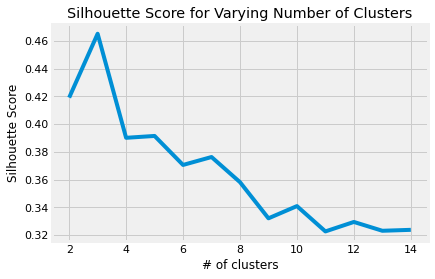

In [76]:
# Plotting the silhouette scores for the varying number of clusters 

plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1], label='Silhouette Score')
plt.title('Silhouette Score for Varying Number of Clusters')
plt.xlabel('# of clusters')
plt.ylabel('Silhouette Score')
plt.show()

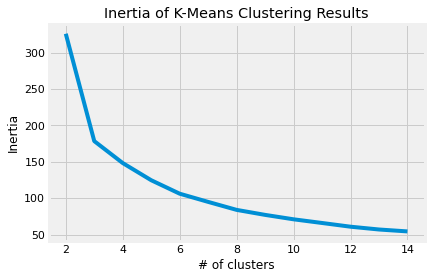

In [77]:
# Plotting the inertia of the K-Means clustering results

plt.plot(pd.DataFrame(ssd)[0], pd.DataFrame(ssd)[1], label='Inertia')
plt.title('Inertia of K-Means Clustering Results')
plt.xlabel('# of clusters')
plt.ylabel('Inertia')
plt.show()

In [78]:
# Finding the optimum K for K-Means

sse_ward = []

for k in range(2, 15):
  h_cluster = AgglomerativeClustering(n_clusters=k)
  h_cluster.fit(df_1)
  sse_ward.append([k, silhouette_score(df_1, h_cluster.labels_)])

print (sse_ward)

[[2, 0.3851116036523478], [3, 0.4307264497346631], [4, 0.4282540034080085], [5, 0.3159366510197099], [6, 0.30423781642601], [7, 0.3077782419522447], [8, 0.2772531263023056], [9, 0.2816415044388118], [10, 0.2593619227974915], [11, 0.27448735770680843], [12, 0.2740520272758343], [13, 0.27636273086468116], [14, 0.28691380472146555]]


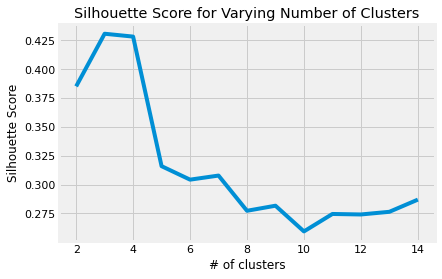

In [79]:
# Silhouette scores for varying number of clusters

plt.plot(pd.DataFrame(sse_ward)[0], pd.DataFrame(sse_ward)[1], label='Silhouette Score')
plt.title('Silhouette Score for Varying Number of Clusters')
plt.xlabel('# of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Low inertia and high silhouette scores are desirable, let "K" (number of clusters) be equal to 3
# This is also in line with what the dendogram suggests

In [80]:
# Hierarchical Cluster Analyses to find initial seeds for k-means 

# Initiating the agglomerative clustering model and fitting it to the dataset.
clustering = AgglomerativeClustering(n_clusters=3)

clustering.fit(df_1)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=3)

In [81]:
# Exploring the results of the agglomerative clustering 

labels_v0 = pd.DataFrame(clustering.labels_)
labels_v0
RFM_0 = pd.concat([df, labels_v0], axis = 1)
RFM_0.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'R', 'F', 'M', 'Cluster']
RFM_0['Cluster'] = RFM_0['Cluster'] + 1
RFM_ward = RFM_0
RFM_ward.head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,Cluster
0,12749.0,4,5,98.35,0.009709,0.4,0.431523,3
1,12820.0,4,4,58.20,0.009709,0.3,0.254658,3
2,12821.0,215,1,19.92,0.692557,0.0,0.086031,2
3,12822.0,71,2,30.80,0.226537,0.1,0.133959,3
4,12824.0,60,1,5.04,0.190939,0.0,0.020484,3
5,12826.0,3,7,122.80,0.006472,0.6,0.539227,1
6,12827.0,6,3,84.21,0.016181,0.2,0.369235,3
7,12828.0,3,6,154.80,0.006472,0.5,0.680190,1
8,12831.0,263,1,34.20,0.847896,0.0,0.148936,2
9,12832.0,33,2,19.90,0.103560,0.1,0.085943,3


In [82]:
# Grouping the customers by cluster

RFM_ward.groupby('Cluster').CustomerID.count()

Cluster
1     567
2     845
3    1734
Name: CustomerID, dtype: int64

In [83]:
# Exploring the mean of the scaled recency by cluster

Cluster_R = pd.DataFrame(RFM_ward.groupby('Cluster').R.mean())

Cluster_R

,R
Cluster,
1,0.162863
2,0.654499
3,0.128235


In [84]:
# Exploring the mean of the scaled frequency by cluster

Cluster_F = pd.DataFrame(RFM_ward.groupby('Cluster').F.mean())

Cluster_F

,F
Cluster,
1,0.470723
2,0.059053
3,0.132295


In [85]:
# Exploring the mean of the scaled monetary value by cluster

Cluster_M = pd.DataFrame(RFM_ward.groupby('Cluster').M.mean())

Cluster_M

,M
Cluster,
1,0.612858
2,0.125889
3,0.167563


In [86]:
# Initial sees for K-Means

clusters_ward = pd.concat([Cluster_R, Cluster_F, Cluster_M], axis = 1)

initial_seeds = clusters_ward.to_numpy()

print (initial_seeds.dtype)
print (initial_seeds)

float64
[[0.16286251 0.4707231  0.61285843]
 [0.65449915 0.05905325 0.1258893 ]
 [0.12823485 0.13229527 0.16756262]]


In [87]:
inertias_in_each_iteration = []
centroids = []
number_of_iterations = []

for i in range(20):
  model = KMeans(n_clusters = 3, init = initial_seeds, max_iter = 500, tol = 1e-10)
  model.fit(df_1)
  inertias_in_each_iteration.append(model.inertia_)
  centroids.append(model.cluster_centers_)
  number_of_iterations.append(model.n_iter_)

print (inertias_in_each_iteration)
print (centroids[-1])
print (number_of_iterations)
labels = model.labels_
labels = pd.Series(labels)
print (silhouette_score(df_1, labels))

[178.3566872656962, 178.3566872656962, 178.3566872656962, 178.3566872656962, 178.3566872656962, 178.3566872656962, 178.3566872656962, 178.3566872656962, 178.3566872656962, 178.3566872656962, 178.3566872656962, 178.3566872656962, 178.3566872656962, 178.3566872656962, 178.3566872656962, 178.3566872656962, 178.3566872656962, 178.3566872656962, 178.3566872656962, 178.3566872656962]
[[0.11299261 0.4605227  0.55445273]
 [0.69928517 0.04747082 0.1402042 ]
 [0.1495507  0.10606796 0.14152682]]
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
0.46529491929856126


In [88]:
inertias_in_each_iteration = []
centroids = []
number_of_iterations = []

for i in range(300):
  model = KMeans(n_clusters=3, init='random', n_init=10, max_iter=500, tol=1e-10)
  model.fit(df_1)
  inertias_in_each_iteration.append(model.inertia_)
  centroids.append(model.cluster_centers_)
  number_of_iterations.append(model.n_iter_)

print (np.mean(inertias_in_each_iteration))
print (centroids[-1])
print (np.mean(number_of_iterations))
labels = pd.Series(labels)
print (silhouette_score(df_1, labels))

178.3558146493397
[[0.11333935 0.45956284 0.55284215]
 [0.69928517 0.04747082 0.1402042 ]
 [0.14950747 0.10541692 0.14098775]]
10.52
0.46529491929856126


In [89]:
# Dataframe showing the customer RFM values and the cluster they belong to

RFM_1 = pd.concat([df, pd.Series(labels)], axis = 1)
RFM_1.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'R', 'F', 'M', 'Cluster']
RFM_1['Cluster'] = RFM_1['Cluster'] + 1
RFM_1.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,Cluster
0,12749.0,4,5,98.35,0.009709,0.4,0.431523,1
1,12820.0,4,4,58.20,0.009709,0.3,0.254658,3
2,12821.0,215,1,19.92,0.692557,0.0,0.086031,2
3,12822.0,71,2,30.80,0.226537,0.1,0.133959,3
4,12824.0,60,1,5.04,0.190939,0.0,0.020484,3


In [91]:
# Descriptives of the clustered df

RFM_1.describe()

,CustomerID,Recency,Frequency,Monetary,R,F,M,Cluster
count,3146.000000,3146.000000,3146.000000,3146.000000,3146.000000,3146.000000,3146.000000,3146.000000
mean,15559.520025,86.230769,2.736173,54.106135,0.275828,0.173617,0.236625,2.292753
std,1559.466439,84.187489,2.117309,51.658956,0.272451,0.211731,0.227562,0.818190
min,12749.000000,1.000000,1.000000,0.390000,0.000000,0.000000,0.000000,1.000000
25%,14227.500000,22.000000,1.000000,15.900000,0.067961,0.000000,0.068323,2.000000
50%,15571.500000,53.000000,2.000000,35.625000,0.168285,0.100000,0.155213,3.000000
75%,16896.500000,134.000000,4.000000,76.500000,0.430421,0.300000,0.335272,3.000000
max,18287.000000,310.000000,11.000000,227.400000,1.000000,1.000000,1.000000,3.000000


In [92]:
RFM_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3146 entries, 0 to 3145
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  3146 non-null   float64
 1   Recency     3146 non-null   int64  
 2   Frequency   3146 non-null   int64  
 3   Monetary    3146 non-null   float64
 4   R           3146 non-null   float64
 5   F           3146 non-null   float64
 6   M           3146 non-null   float64
 7   Cluster     3146 non-null   int32  
dtypes: float64(5), int32(1), int64(2)
memory usage: 184.5 KB


In [93]:
# Grouping the customers by cluster

RFM_1.groupby('Cluster').CustomerID.count()

Cluster
1     727
2     771
3    1648
Name: CustomerID, dtype: int64

In [94]:
# Exploring the mean of the recency variable for each cluster

Clusters_Recency = pd.DataFrame(RFM_1.groupby('Cluster').Recency.mean())

Clusters_Recency

,Recency
Cluster,
1,35.914718
2,217.079118
3,47.211165


In [95]:
# Exploring the mean of the frequency variable for each cluster

Clusters_Frequency = pd.DataFrame(RFM_1.groupby('Cluster').Frequency.mean())

Clusters_Frequency

,Frequency
Cluster,
1,5.605227
2,1.474708
3,2.060680


In [96]:
# Exploring the mean of the monetary variable for each cluster

Clusters_Monetary = pd.DataFrame(RFM_1.groupby('Cluster').Monetary.mean())

Clusters_Monetary

,Monetary
Cluster,
1,126.256314
2,32.217756
3,32.518004


In [97]:
Clusters_R = pd.DataFrame(RFM_1.groupby('Cluster').R.mean())

Clusters_R

,R
Cluster,
1,0.112993
2,0.699285
3,0.149551


In [98]:
Clusters_F = pd.DataFrame(RFM_1.groupby('Cluster').F.mean())

Clusters_F

,F
Cluster,
1,0.460523
2,0.047471
3,0.106068


In [99]:
Clusters_M = pd.DataFrame(RFM_1.groupby('Cluster').M.mean())

Clusters_M

,M
Cluster,
1,0.554453
2,0.140204
3,0.141527


In [100]:
# CLuster centroids

clusters_1 = pd.concat([Clusters_Recency, Clusters_Frequency, Clusters_Monetary, Cluster_R, Cluster_F, Cluster_M], axis = 1)

clusters_1

,Recency,Frequency,Monetary,R,F,M
Cluster,,,,,,
1,35.914718,5.605227,126.256314,0.162863,0.470723,0.612858
2,217.079118,1.474708,32.217756,0.654499,0.059053,0.125889
3,47.211165,2.060680,32.518004,0.128235,0.132295,0.167563


In [101]:
# Creating 3 new dataframes, one for each cluster

cluster_1 = RFM_1[RFM_1['Cluster']==1]
cluster_2 = RFM_1[RFM_1['Cluster']==2]
cluster_3 = RFM_1[RFM_1['Cluster']==3]
cluster_1.head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,Cluster
0,12749.0,4,5,98.35,0.009709,0.4,0.431523,1
5,12826.0,3,7,122.80,0.006472,0.6,0.539227,1
7,12828.0,3,6,154.80,0.006472,0.5,0.680190,1
15,12840.0,144,4,138.60,0.462783,0.3,0.608828,1
17,12843.0,66,8,123.20,0.210356,0.7,0.540989,1
23,12853.0,135,6,202.20,0.433657,0.5,0.888992,1
24,12854.0,79,3,158.30,0.252427,0.2,0.695608,1
25,12856.0,8,6,44.58,0.022654,0.5,0.194661,1
28,12867.0,27,7,53.74,0.084142,0.6,0.235012,1
30,12871.0,85,2,178.20,0.271845,0.1,0.783269,1


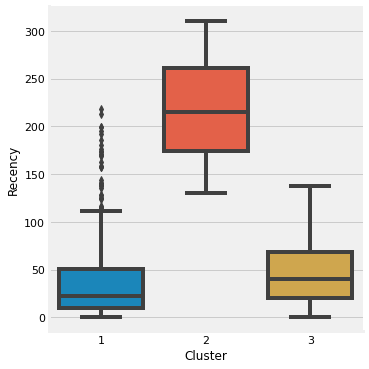

In [102]:
# Categorical boxplot for the clusters based on the recency variable

g = sns.catplot(x='Cluster', y='Recency', data=RFM_1, kind='box')

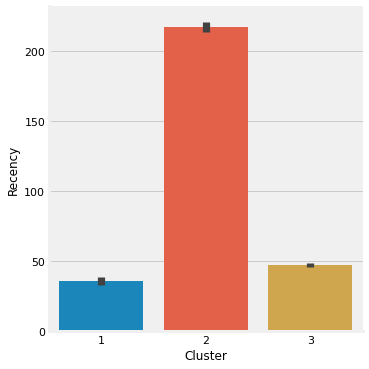

In [103]:
# Categorical barplot for the clusters based on the recency variable

g = sns.catplot(x='Cluster', y='Recency', data=RFM_1, kind='bar')

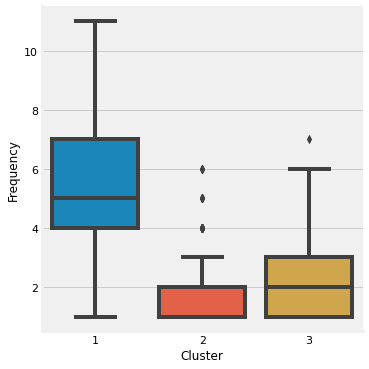

In [104]:
# Categorical boxplot for the clusters based on the frequency variable

g = sns.catplot(x='Cluster', y='Frequency', data=RFM_1, kind='box')

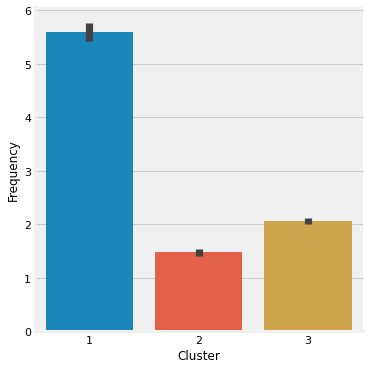

In [105]:
# Categorical barplot for the clusters based on the frequency variable

g = sns.catplot(x='Cluster', y='Frequency', data=RFM_1, kind='bar')

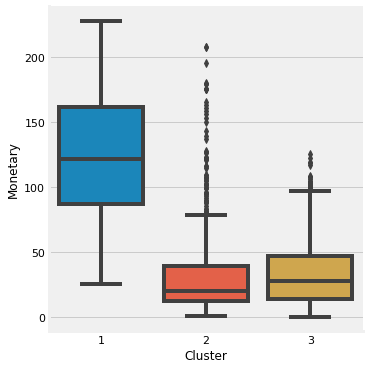

In [106]:
# # Categorical boxplot for the clusters based on the monetary variable

g = sns.catplot(x='Cluster', y='Monetary', data=RFM_1, kind='box')

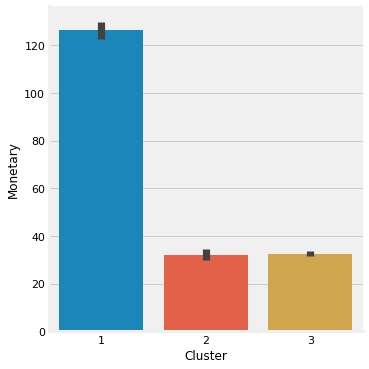

In [107]:
# Categorical barplot for the clusters based on the monetary variable

g = sns.catplot(x='Cluster', y='Monetary', data=RFM_1, kind='bar')

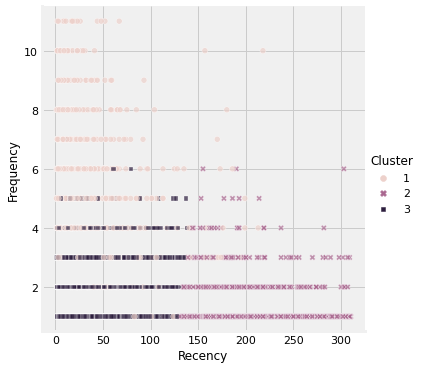

In [108]:
# Relational plot for the three clusters based on recency and frequency

sns.relplot(x='Recency', y='Frequency', data=RFM_1, kind='scatter', 
            hue='Cluster', style='Cluster', alpha=0.7)
plt.show()

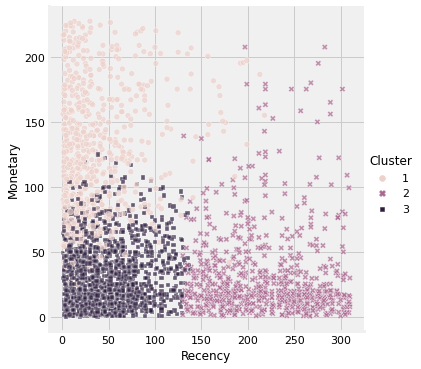

In [109]:
# Relational plot for the three clusters based on recency and monetary

sns.relplot(x='Recency', y='Monetary', data=RFM_1, kind='scatter', 
            hue='Cluster', style='Cluster', alpha=0.7)
plt.show()

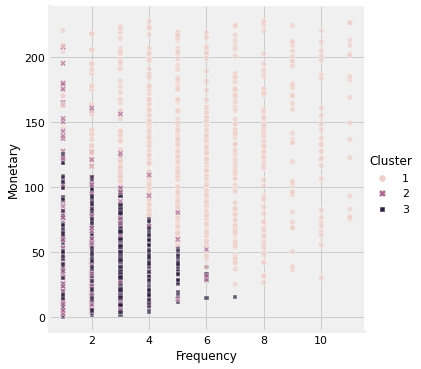

In [110]:
# Relational plot for the three clusters based on frequency and monetary

sns.relplot(x='Frequency', y='Monetary', data=RFM_1, kind='scatter', 
            hue='Cluster', style='Cluster', alpha=0.7)
plt.show()

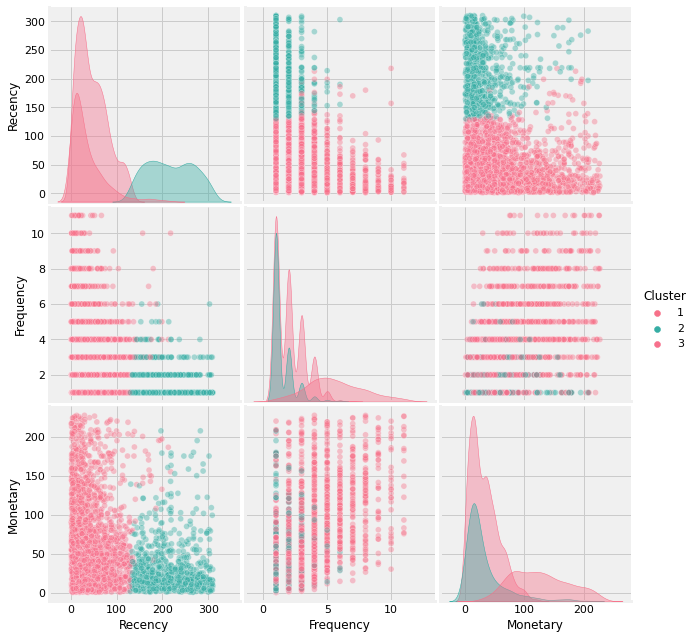

In [111]:
# Exploring the pairplot between recency, frequency and monetary 

sns.pairplot(RFM_1, vars=['Recency', 'Frequency', 'Monetary'], hue='Cluster',
             diag_kind='auto', diag_kws={'alpha': 0.4}, corner=False, palette='husl', plot_kws={'alpha':0.4}, height=3, aspect=1)

In [112]:
RFM_1.Recency.mean()

86.23076923076923

In [113]:
RFM_1.Frequency.mean()

2.7361729179911

In [114]:
RFM_1.Monetary.mean()

54.10613477431657